In [141]:
#necessary imports
import matplotlib.pyplot as plt  #plotting
from matplotlib.colors import LogNorm
import matplotlib
import numpy as np
import astropy.units as u
from astropy.constants import G
from astropy import constants as const
import scipy.optimize as so #for density contours

#fitting ellipse
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse

#Single galaxy data reading
from ReadFile import Read
from CenterOfMassSingle import CenterOfMass as COMS
from MassProfileSingle import MassProfile as MPS
from MassProfileSingle import mEncPlot as MPPS
from GalaxyMassSingle import ComponentMass as CMS

#Combined galaxy data reading
from ReadCombined import ReadCombined
from CenterOfMassCombined import CenterOfMass as COMC
from MassProfileCombined import MassProfile as MPC
from MassProfileCombined import mEncPlot as MPPC
from GalaxyMassCombined import ComponentMass as CMC

In [3]:
# TASK LIST
# COMPLETE 1. identify COM of merged galaxy and its snapshot
# COMPLETE 2. isolated merged galaxy snapshots
# COMPLETE 3. identify positions of combined MW-M31 halo particles with in COM reference frame
# COMPLETE 4. plot xy, xz, yz projections of dark matter halo (can animate)
# COMPLETE 5. Find hernquist profile scale radius
# COMPLETE 6. translate coordinate axes s.t. AM points in z-direction
# COMPLETE 7. Plot isodensity contours at R200 for each projection 
# 8. Fit ellipse to isodensity contour using photutils to find ellipticity of each axis. Use this to find axis ratios
# 9. do this for each snapshot and plot axis ratios versus time. 
# 10. (for fun) create 3D plots of halo

#REMINDER: remember to get the high resolution files from nimoy. Can't download them for some reason

#NOTE: Particle types: 1-Halo, 2-Disk Stars, 3-Bulge Stars

In [4]:
#Find snapshot where merger is completed (t=6 Gyr)

#Time in each snapshot is recorded in Myr (1 Gyr = 1000 Myr)
#Snapshot at 6 Gyr is SNAPSHOT 420 (t = 5.999 Gyr)
#SNAPSHOT 420 ONWARDS (420-800)

#Scale height of 110 kpc fits best

#plotting rho_crit density contour as some percentage of rho_halo
#Critical Density of Universe: 9e(-27) kg/m^3 = 132.75 Msun/kpc^3

#total halo mass is 390e10 Msun

In [5]:
def Combine_Snap_Data(snap_id):
    """This function extracts the data of two snapshots of the same 
    snapshot number from different galaxies and combines their data arrays.
    We are working with the MW and M31 exclusively here. This data is then 
    saved as a text file in the same format as the input file.

    PARAMETERS
    ----------
        snap_id: 'int'
            The snapshot number whose data will be combined

    OUTPUTS
    -------
        combined_data: 'numpy array of floats'
            An array that contains the combined data of the
            MW and M31 for the inputted snapshot number
        time: 'float'
            The time corresponding to the given snapshot in Myr
    """
    #Create filenames
    MW_file = r"MW\MW_" + "{:03d}".format(snap_id) + ".txt"
    M31_file = r"M31\M31_" + "{:03d}".format(snap_id) + ".txt"

    #extract data from files
    MW_time, MW_total, MW_data = Read(MW_file)
    M31_time, M31_total, M31_data = Read(M31_file)

    #combine the data into one numpy array
    combined_data = np.concatenate((MW_data,M31_data))

    #total number of particles
    tot_part = MW_total + M31_total
    
    #time
    time = MW_time
    
    #write data out to text file in same format as input files
    #output filename
    filename = 'MW_M31_' + "{:03d}".format(snap_id) + '.txt'

    #write data to file
    np.savetxt(filename, combined_data,fmt = "%13.4f"*8, comments='#', 
                   header="{:>13s}{:>13s}{:>13s}{:>13s}{:>13s}{:>13s}{:>13s}{:>13s}"\
                   .format('type','m', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
    
    return combined_data, time  

In [185]:
# Code for plotting contours
# from https://gist.github.com/adrn/3993992

#imports
# for contours
import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}

    ### Adjust Here #### 
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))  #change the 0.99 to whatever you want it to be
    
    
    # You might need to add a few levels
    onetwo_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, onetwo_sigma, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68','0.8', '0.95', '0.99'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

In [ ]:
# Plot merged halo density  
fig, ax = plt.subplots(figsize=(12, 10))

#plot histogram of xy-plane projection
plt.hist2d(x[halo_index], y[halo_index], bins=1000, norm=LogNorm(), cmap='magma')

#colorbar
cbar = plt.colorbar()
cbar.set_label("Number of halo particles per bin", fontsize=15)

density_contour(x[halo_index], y[halo_index], 80, 80, ax=ax, colors=['yellow', 'blue', 'black', 'red'])

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-2000,2000)
plt.xlim(-2000,2000)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

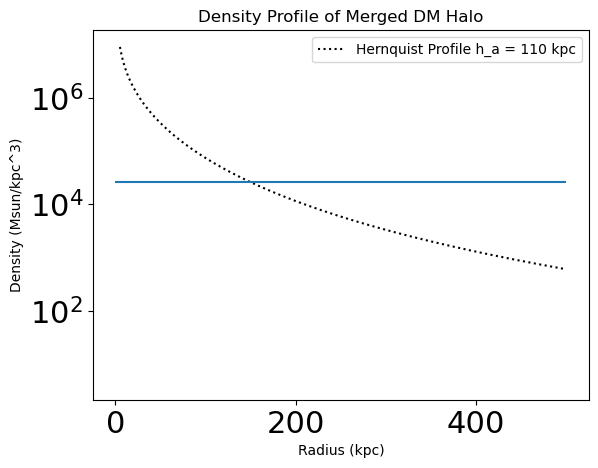

In [265]:
#Find total mass of halo
data = ReadCombined(r'Combined\MW_M31_420.txt')

M_P = MPC(r'Combined\MW_M31', 600)

#total mass is 390e10 Msun
halo_particles = np.where(data['type']==1)
total_mass = sum(data['m'][halo_particles])*1e10 #Msun

#initialize radius array and scale height
r = np.arange(5, 500, 2) #kpc. Each index is the radius value in kpc multiplied by 10
scale_h = 110  #kpc

#find Hernquist mass and density profiles. 
mass,rho = M_P.hernquistMass(r, scale_h, total_mass)

#determine mass profile for determining scale height of Hernquist profile
mass_profile = M_P.massEnclosed(1,r)

#Make plot of Hernquist Density Profile
plt.plot(r, rho, color='black', ls=':', label=f'Hernquist Profile h_a = {scale_h} kpc') #Hernquist
#plt.plot(r, mass_profile, color='blue', label='Halo Mass Profile') #determined density profile
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (Msun/kpc^3)')
plt.title('Density Profile of Merged DM Halo')
plt.semilogy()
plt.legend()

#best fit chosen s.t. mass profile matches at larger radii. Found best fit for h_a = 55 kpc
#NOW, using my new scale radius, I can use my Hernquist density profile with this scale radius, and then find my halo edgeat R200.

#rho_crit = 132.75 Msun/kpc^3
#R200 at rho = 265.5e2 Msun/kpc^3

#plotting line of consant density at 200*rho_crit
plt.hlines(265.5e2, 0, 500)

In [269]:
#finding the R200 radius
#need to find the index of the density profile that gives density value closest to 26550 Msun/kpc^3

#R200 radius: Where the mean density within a sphere of radius R200 has a density of 200*rho_crit

for index in range(len(r)):
    print(rho[index].value, 'index:', index)
    
#create loop that checks if the density at whatever index is larger or smaller than the target density. if its smaller we save the index, if its 
#larger then we stop the loop and the index that we saved is the index for the R200 radius.

#INDEX: 72

8978709.043996464 index: 0
6090063.18598283 index: 1
4501881.199765496 index: 2
3503713.83236903 index: 3
2822401.129169303 index: 4
2330537.66268384 index: 5
1960727.9494129708 index: 6
1673997.0640818838 index: 7
1446252.8977536226 index: 8
1261812.0337609802 index: 9
1110033.5613301324 index: 10
983449.2607219655 index: 11
876667.7393418313 index: 12
785702.9649733303 index: 13
707547.1265184614 index: 14
639890.0730323682 index: 15
580929.854081577 index: 16
529241.6461110186 index: 17
483685.11798305967 index: 18
443337.7121790311 index: 19
407445.77198298136 index: 20
375388.19293893507 index: 21
346649.01527465676 index: 22
320796.4987422278 index: 23
297466.9640152873 index: 24
276352.1843486328 index: 25
257189.45296304554 index: 26
239753.68906806954 index: 27
223851.11278284588 index: 28
209314.13871942912 index: 29
195997.2243791074 index: 30
183773.47266936404 index: 31
172531.83451296898 index: 32
162174.7923394935 index: 33
152616.43147037944 index: 34
143780.82632592344

In [271]:
R200 = r[72]*u.kpc
R200
#the same R200 radius at snapshot 600 and 420. We can use it for all snapshots

<Quantity 149. kpc>

In [275]:
#Reframing coordinates s.t. AM points in z-direction
#from Lab7

def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) 
            such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) 
            such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    
    # normalize the angular momentum vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to
    # z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel


In [277]:
#Define all particle positions in COM reference frame

#create COM object using halo particles
COM = COMC("Combined\MW_M31_600.txt",1)

#define COM position of merged galaxy
COM_p = COM.COM_P(delta=0.1)

#Determine positions of disk particles relative to COM 
x = COM.x - COM_p[0].value 
y = COM.y - COM_p[1].value 
z = COM.z - COM_p[2].value 

#repeat for velocity
#define COM velocity
COM_v = COM.COM_V(COM_p[0], COM_p[1], COM_p[2])

#Find velocities in COM reference frame
vx = COM.vx - COM_v[0].value
vy = COM.vy - COM_v[1].value
vz = COM.vz - COM_v[2].value

#create arrays for position and velocity for input into RotateFrame function
r = np.array([x,y,z]).T # transposed 
v = np.array([vx,vy,vz]).T

<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
C:\Users\ethan\AppData\Local\Temp\ipykernel_18496\3697990661.py:4: SyntaxWarning: invalid escape sequence '\M'
  COM = COMC("Combined\MW_M31_600.txt",1)


In [278]:
C_pos, C_vel = RotateFrame(r,v) #rotated s.t. AM points in z-direction

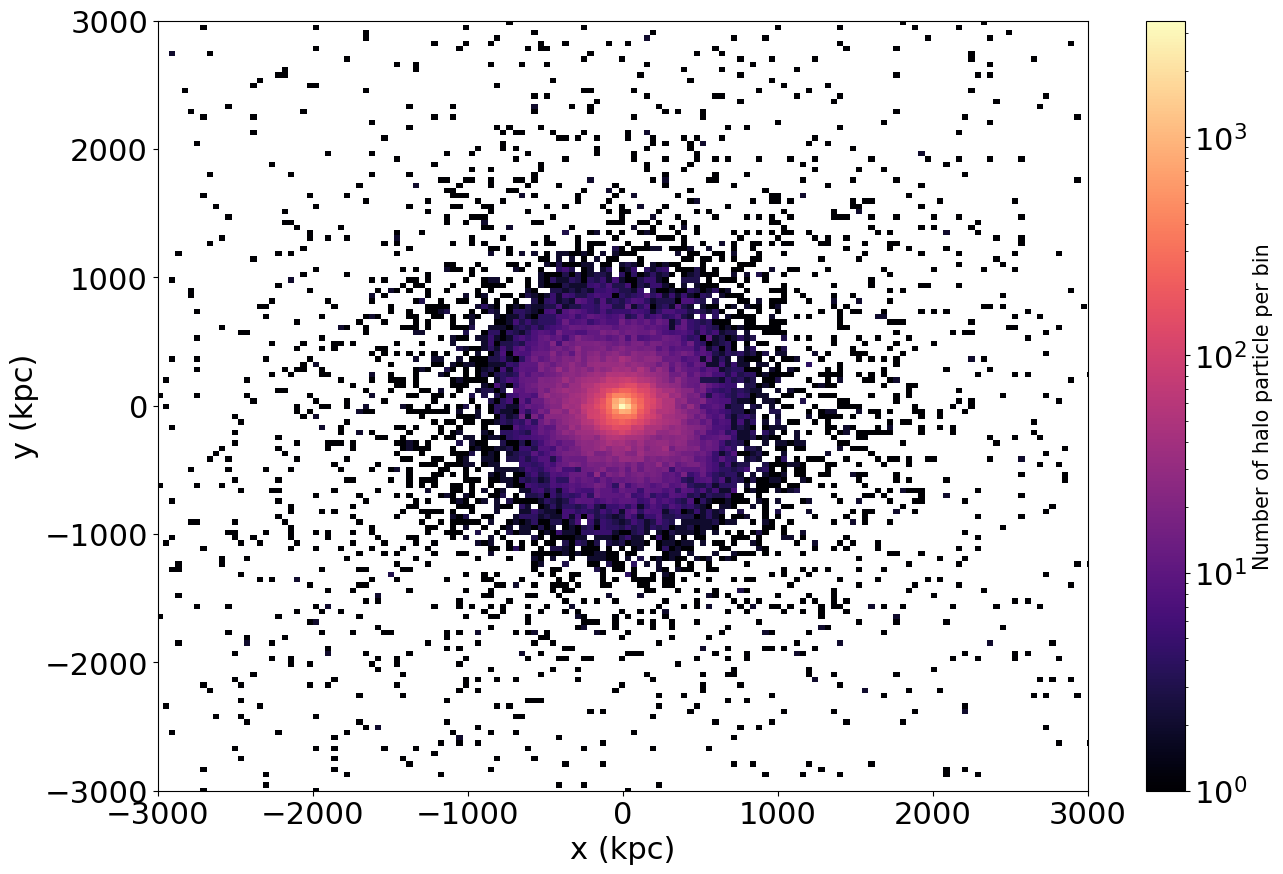

In [281]:
#plotting projection of xy-plane for rotated coordinate system

#coordinate data
cx = C_pos[:,0]
cy = C_pos[:,1]
cz = C_pos[:,2]

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(15, 10))

# plot the particle density for M31 , 2D histogram
plt.hist2d(cx, cy, bins=500, norm=LogNorm(), cmap='magma')

cbar = plt.colorbar()
cbar.set_label("Number of halo particle per bin", fontsize=15)

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-3000,3000)
plt.xlim(-3000,3000)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#plotting density contours
#density_contour(x, y, 100, 100, ax=ax, colors=['yellow', 'blue', 'black', 'red'])

In [283]:
#FROM HERE
#plot isodensity contour at 200*rho_crit. This contour is the edge of the halo.
#positions should already be in COM reference frame

#constuct histogram to fit ellipse
counts, xedges, yedges = np.histogram2d(cx, cy, bins = 100, range = ((-1000, 1000), (-1000, 1000)))
#our bin size is:
x_binsize = xedges[1] - xedges[0]
y_binsize = yedges[1] - yedges[0]

#converting the center into pixel units
x_cen_pixel = -xedges[0]/x_binsize
y_cen_pixel = -yedges[0]/y_binsize

C:\Users\ethan\AppData\Local\Temp\ipykernel_18496\3292013223.py:14: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(counts).T, cmap = cm, origin = "lower") #imshow transposes the matrix, so transposing again to reverse


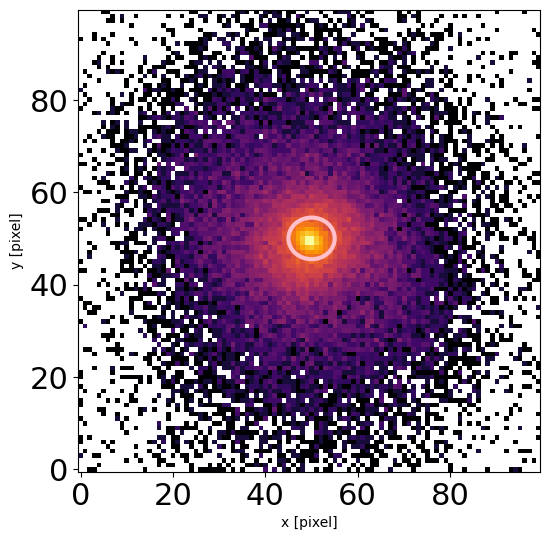

In [285]:
#constructing guess ellipse
#defining the ellipse geometry
geometry = EllipseGeometry(x0 = x_cen_pixel, y0 = y_cen_pixel, sma = 100/x_binsize, eps = 0.1, pa = 0)
#sma is the semi-major axis, eps is the ellipticity and pa is the position angle


#not relevent for function here.
#constructing the ellipse
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma, geometry.sma * (1 - geometry.eps), 
                           geometry.pa) 

#plotting guess ellipse
fig = plt.figure(figsize = (6, 6))
ax0 = fig.add_subplot(1, 1, 1)
cm = plt.cm.inferno
im = plt.imshow(np.log10(counts).T, cmap = cm, origin = "lower") #imshow transposes the matrix, so transposing again to reverse
ax0.set_xlabel('x [pixel]')
ax0.set_ylabel('y [pixel]')
aper.plot(color = 'pink', linewidth = 3)
plt.show()

In [287]:
ellipse = Ellipse(counts.T, geometry) #initializing the ellipse object
#you need to transpose the counts matrix to reverse the effect of transposition that Ellipse does internally
isolist = ellipse.fit_image() 
#if isolist doesn't work, it might be because the initial ellipse guess was initialized with a default value that results in an empty sequence
#AKA make a different initial guess

C:\Users\ethan\AppData\Local\Temp\ipykernel_18496\1072447314.py:4: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.log10(counts).T, cmap = cm, origin = "lower")


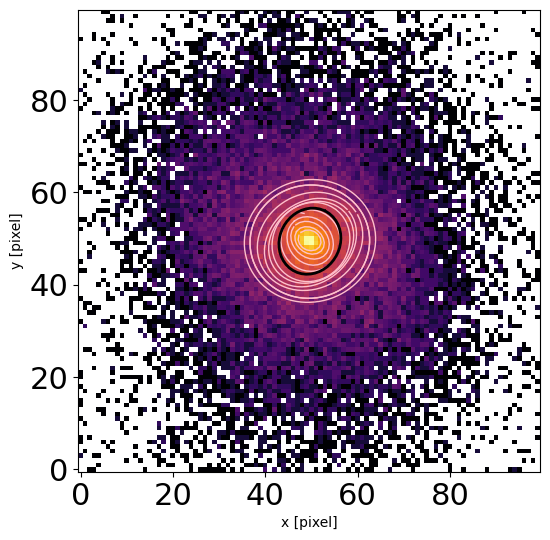

In [288]:
fig = plt.figure(figsize = (8, 6))
ax0 = fig.add_subplot(1, 1, 1)
cm = plt.cm.inferno
im = plt.imshow(np.log10(counts).T, cmap = cm, origin = "lower")
ax0.set_xlabel('x [pixel]')
ax0.set_ylabel('y [pixel]')

#defining the semi-major axes in pixel coordinates
sma_min = 50/x_binsize
sma_max = 300/x_binsize
separation = 20/x_binsize
sma_array = np.arange(sma_min, sma_max, separation) #each contour will be separated by 10 kpc

for my_sma in sma_array:
    iso = isolist.get_closest(my_sma)
    #the get_closest method obtains the elliptical contour whose semi-major axis is closest to what you want
    x, y = iso.sampled_coordinates()
    if my_sma == 150/x_binsize:
        ax0.plot(x,y, color='black', lw=2)
    else:
        ax0.plot(x, y, color = 'pink', linewidth = 1)

plt.show()

#we know R200 ~ 150kpc, so we plot best fit for that

In [289]:
sma_kpc = 150 #R200 value in kpc
sma_pixel = 150/x_binsize #rR200 in pixel units

#obtain the elliptical contour whose semi-major axis is closest to 150 kpc
iso_150 = isolist.get_closest(sma_pixel)

eps_150 = iso_150.eps
print("Ellipticity of 150 kpc elliptical contour in the xy-projection:", np.round(eps_150, 2))

#found a value of 0.31 for the ellipticity.

Ellipticity of 150 kpc elliptical contour in the xy-projection: 0.11


In [ ]:
def ContourPlotting(pos_data, init_sma=100, R200=150, binsize=100, sma_min=20, sma_max=300):
    """This function creates isodensity contours for different radii for a
    number desnity plot of halo particles. It finds the best fit ellipse
    for the edge of the halo.

    PARAMETERS
    ----------
        pos_data: 'np.ndarray'
            The 2D positional data for the halo particles submitted as an
            array where pos_data[0] is one coordinate, and pos_data[1] is the
            second. (kpc)
        init_sma: 'int'
            The initial semi-major axis guess. (kpc)
        R200: 'float'
            The R200 radius, representing the edge of the halo (kpc).
            R200 = 149.8 kpc throughout the simulation.
        binsize: 'int'
            The binsize.
        sma_min: 'int'
            Minimum semi-major axis value (kpc)
        sma_max: 'int
            Max semi-major axis value (kpc)

    OUTPUTS
    -------
        eps: 'float'
            The ellipticity of the best fit ellipse. The sma of this
            ellipse is the R200 radius.
    """